## Importing libaries

In [1]:
import pandas as pd

from sklearn import preprocessing 
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics, neighbors
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import os
os.chdir('../Preprocessing')
from normalization import normalize_corpus


## Reading the data

In [2]:
df = pd.read_csv('../Data_collection/dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198125 entries, 0 to 198124
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  198125 non-null  int64 
 1   url         198125 non-null  object
 2   content     198125 non-null  object
 3   summary     197911 non-null  object
 4   category    198125 non-null  object
dtypes: int64(1), object(4)
memory usage: 7.6+ MB


## Normalizing the data

#### The implementation of this is available under normalization.py located in preprocessing folder

In [3]:
if not os.path.exists('../Data_collection/dataset_filtered.pickle'):
    df['filtered_content'] = df['content'].apply(normalize_corpus)
    # df.to_csv('../Data_collection/dataset_filtered.csv')
    df.to_pickle('../Data_collection/dataset_filtered.pickle')
else:
    df = pd.read_pickle('../Data_collection/dataset_filtered.pickle')
df.head()

,Unnamed: 0,url,content,summary,category,filtered_content
0,0,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Paris/London/Atlanta: Federal Reserve Bank of ...,Paris/London/Atlanta: Federal Reserve Bank of ...,b,federal reserve bank philadelphia president ch...
1,1,http://www.nasdaq.com/article/plosser-fed-may-...,Women Who Invest: VC Include CEO\n\nAbout 14% ...,Women Who Invest: VC Include CEOAbout 14% of f...,b,woman who invest vc include ceo about fund man...
2,2,http://www.marketwatch.com/story/feds-plosser-...,PARISn — The Federal Reserve may have to accel...,PARISn — The Federal Reserve may have to accel...,b,parisn the federal reserve may accelerate pace...
3,3,http://www.fxstreet.com/news/forex-news/articl...,FXStreet (Łódź) - Philadelphia Fed President C...,FXStreet (Łódź) - Philadelphia Fed President C...,b,fxstreet łódź philadelphia fed president charl...
4,4,http://www.iii.co.uk/news-opinion/reuters/news...,Be up to £45k better off .\n\nResearch shows y...,Be up to £45k better off .\nResearch shows you...,b,be good research show could well year invest i...


/home/bml_casp15/anaconda3/envs/8735/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Before sampling')

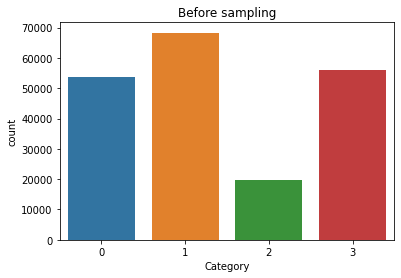

In [4]:
# Encode labels in column 'category'.
label_encoder = preprocessing.LabelEncoder() 
df['category']= label_encoder.fit_transform(df['category']) 

sns.countplot(df.category)
plt.xlabel('Category')
plt.ylabel('count')
plt.title('Before sampling')

/home/bml_casp15/anaconda3/envs/8735/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'After sampling')

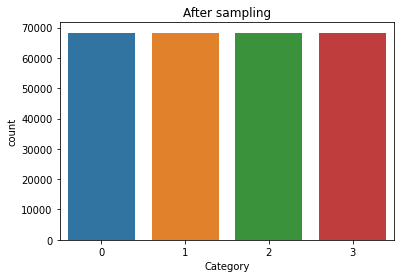

In [5]:
#Sampling the data

df0 = df[df.category==0]
df1 = df[df.category==1]
df2 = df[df.category==2]
df3 = df[df.category==3]

samples = df.category.value_counts().tolist()

sample_count = samples[0]

df0 = resample(df0, 
                   replace=True,   
                   n_samples=sample_count, 
                   random_state=1130)
df1 = resample(df1, 
                   replace=True,    
                   n_samples=sample_count,
                   random_state=123)
df2 = resample(df2, 
                   replace=True,    
                   n_samples=sample_count,
                   random_state=123)
df3 = resample(df3, 
                   replace=True,    
                   n_samples=sample_count,
                   random_state=123)


df_sampled = pd.concat([df0,df1,df2,df3])

df= df_sampled



sns.countplot(df_sampled.category)
plt.xlabel('Category')
plt.ylabel('count')
plt.title('After sampling')

## Split dataset into training set and test set

In [6]:
training_set, test_set, training_labels, test_labels = train_test_split(df["filtered_content"], df["category"], test_size=0.33, random_state=42)

## Latent Semantic Analysis using Bag of words features

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords

stopword_list = stopwords.words('english')
dtm = CountVectorizer(max_df=0.7, min_df=5, token_pattern="[a-z']+", 
                      stop_words=stopword_list, max_features=2000) # Only top 2000 most frequently ocurring words are considered
dtm.fit(training_set)

dtm_mat = dtm.transform(test_set)
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(dtm_mat)
tsvd_mat = tsvd.transform(dtm_mat)
km = KMeans(n_clusters=4, n_init=50, max_iter=1000) # Instantiate KMeans clustering
km.fit(tsvd_mat) # Run KMeans clustering

acc = metrics.accuracy_score(test_labels, km.labels_)
print('Accuracy: {}'.format(str(acc * 100) + '%'))

Accuracy: 29.75076500066522%


## Latent Semantic Analysis using TD-IDF features

In [8]:
#Tfidf 
tfidvectorizer = TfidfVectorizer(min_df=2, 
                                 ngram_range=(2,2),
                                 smooth_idf=True,
                                 use_idf=True)
tfid_train_features = tfidvectorizer.fit_transform(training_set)

tfid_test_features = tfidvectorizer.transform(test_set)

tsvd = TruncatedSVD(n_components=200)
tsvd.fit(tfid_test_features)
tsvd_mat = tsvd.transform(tfid_test_features)
km = KMeans(n_clusters=4, n_init=50, max_iter=1000) # Instantiate KMeans clustering
km.fit(tsvd_mat) # Run KMeans clustering
acc = metrics.accuracy_score(test_labels, km.labels_)
print('Accuracy: {}'.format(str(acc * 100) + '%'))

Accuracy: 22.499889130338374%


## Latent Semantic Analysis using TF-IDF features and UMAP to reduce data dimension

In [9]:
import umap

dimensions = [400, 800, 1200, 1600, 2000]
for dimension in dimensions:
    reducer = umap.UMAP(random_state=42, n_components=dimension)
    embedding = reducer.fit_transform(tfid_test_features)
    tsvd = TruncatedSVD(n_components=200)
    tsvd.fit(embedding)
    tsvd_mat = tsvd.transform(embedding)
    km = KMeans(n_clusters=4, n_init=50, max_iter=1000) # Instantiate KMeans clustering
    km.fit(tsvd_mat) # Run KMeans clustering
    acc = metrics.accuracy_score(test_labels, km.labels_)
    print('UMAP dimension: {}, Accuracy: {}'.format(str(dimension), str(acc * 100) + '%'))
    
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     c=training_labels)
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the dataset', fontsize=24);

/home/bml_casp15/anaconda3/envs/8735/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


UMAP dimension: 400, Accuracy: 27.00563217881059%
UMAP dimension: 800, Accuracy: 22.71054148742738%
UMAP dimension: 1200, Accuracy: 21.915606013570446%
UMAP dimension: 1600, Accuracy: 22.505432613419664%
UMAP dimension: 2000, Accuracy: 21.883453811698967%
